In [1]:
# !pip install pytorch-lightning pycocotools
!export CUDA_VISIBLE_DEVICES=3
!pip install -e .

import os,threading; os.getpid(), threading.current_thread().ident

(3345773, 140289302491520)

In [2]:
import glob
import os
import torch
import torchvision
import torchvision.transforms as transforms
import cv2

from PIL import Image

from pycocotools import mask as mask_utils

import json
import numpy as np
from tqdm import tqdm

def get_bbox_from_mask(target):
    bbox = []
    valid_index = []
    for idx, mask in enumerate(target):
        if mask.sum() > 0.:
            coord_y, coord_x = torch.where(mask > 0)
            if len(coord_x) == 0:
                import pdb; pdb.set_trace()
            x1, y1 = coord_x.min(), coord_y.min()
            x2, y2 = coord_x.max(), coord_y.max()
            bbox.append(torch.stack([x1, y1, x2, y2])) # (Image Coordinate)
            valid_index.append(idx)

    return torch.stack(bbox), valid_index

input_transforms = transforms.Compose([
    transforms.Resize((160, 256)),
    transforms.ToTensor(),
])

target_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((160, 256)),
])

class SA1B_Dataset(torchvision.datasets.ImageFolder):
    """A data loader for the SA-1B Dataset from "Segment Anything" (SAM)
    This class inherits from :class:`~torchvision.datasets.ImageFolder` so
    the same methods can be overridden to customize the dataset.
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)
     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, _ = self.imgs[index] # discard automatic subfolder labels
        image = self.loader(path)
        masks = json.load(open(f'{path[:-3]}json'))['annotations'] # load json masks
        target = []

        for m in masks:
            # decode masks from COCO RLE format
            target.append(mask_utils.decode(m['segmentation']))
        target = np.stack(target, axis=-1)

        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)
        target[target > 0] = 1 # convert to binary masks

        return image, target

    def __len__(self):
        return len(self.imgs)


input_reverse_transforms = transforms.Compose([
    transforms.ToPILImage(),
])

import matplotlib.pyplot as plt
def show_image(image, target, row=12, col=12):
    # image: numpy image
    # target: mask [N, H, W]
    bbox, vidx = get_bbox_from_mask(target)
    target = target[vidx]
    fig, axs = plt.subplots(row, col, figsize=(20, 12))
    for i in range(row):
        for j in range(col):
            if i*row+j < target.shape[0]:
                box = bbox[i*row+j]
                canvas = image.copy()
                cv2.rectangle(canvas, (box[0].item(), box[1].item()),
                                (box[2].item(), box[3].item()), (255, 0, 0))
                axs[i, j].imshow(canvas)
                axs[i, j].imshow(target[i*row+j], alpha=0.5)
            else:
                axs[i, j].imshow(image)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()


/home/boshulei/.conda/envs/bslei/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 160, 256]) torch.Size([45, 160, 256])


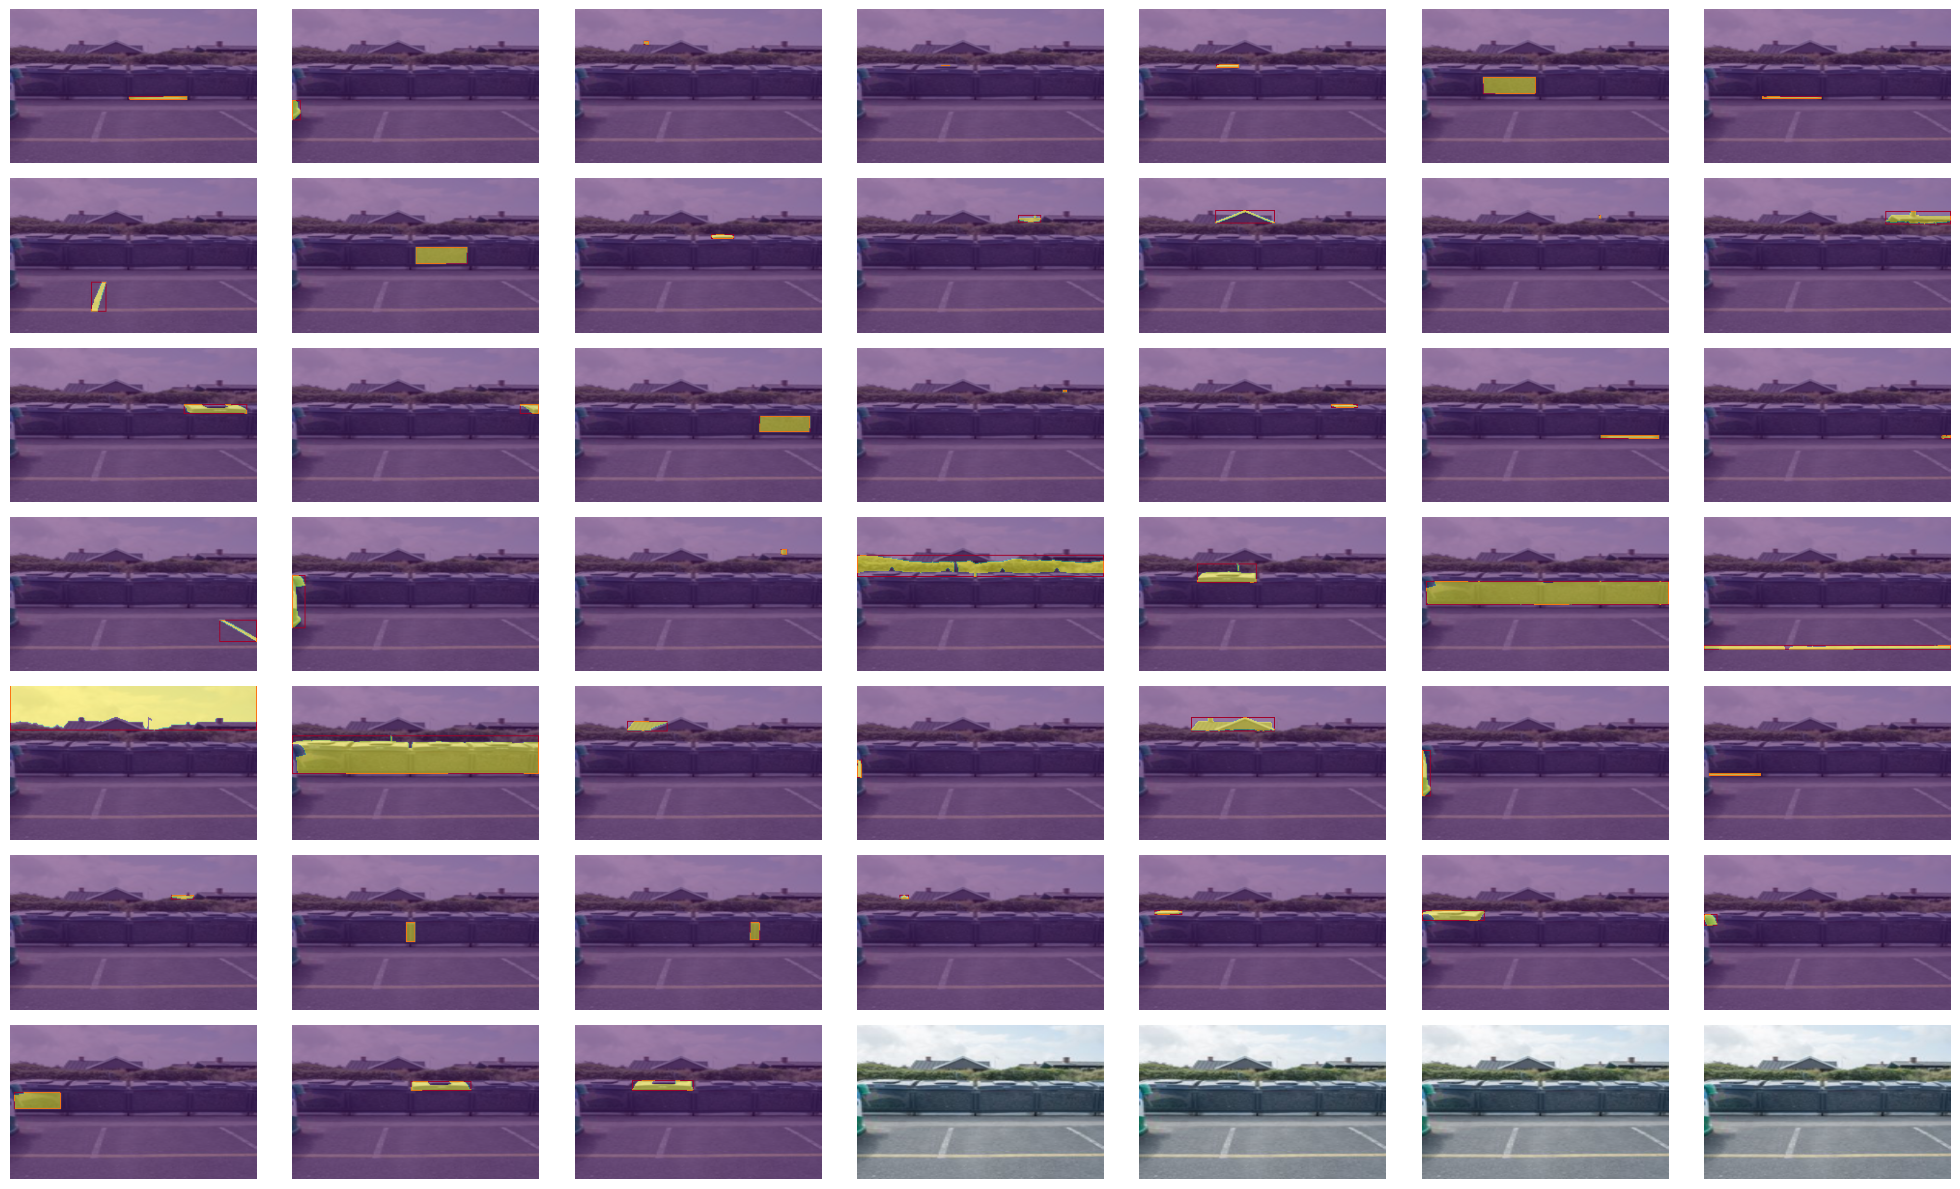

In [3]:
path = './sa1b'
dataset = SA1B_Dataset(path, transform=input_transforms, target_transform=target_transforms)
image, target = dataset.__getitem__(3535)
print(image.shape, target.shape)

image = input_reverse_transforms(image)
image = np.array(image)
show_image(image, target, 7, 7)

In [4]:
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# you may want to make a local copy instead of pip install,
# as you may need to modify their code
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [5]:
from segment_anything import sam_model_registry
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")

print(sam)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [6]:
# SAM on Low resolution images

from segment_anything import SamPredictor

sam.cuda()
predictor = SamPredictor(sam)

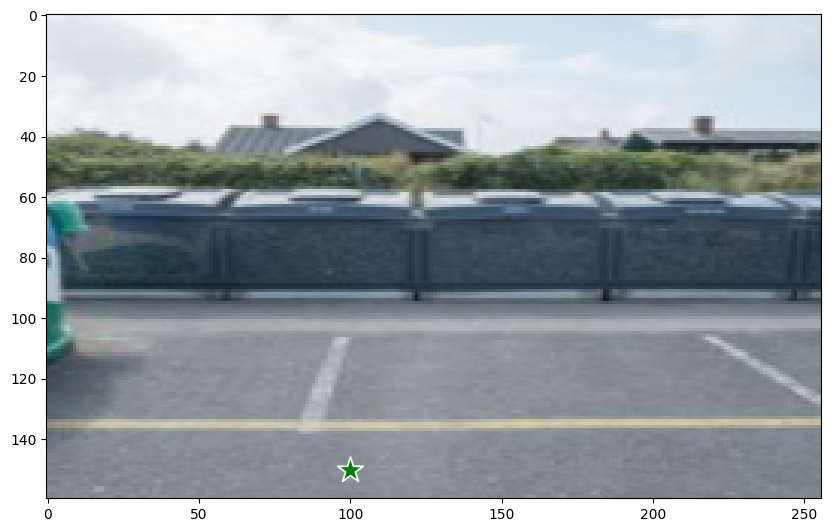

In [7]:
# SAM Official Prediction Demo
predictor.set_image(image)

# set the click point
input_point = np.array([[100, 150]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

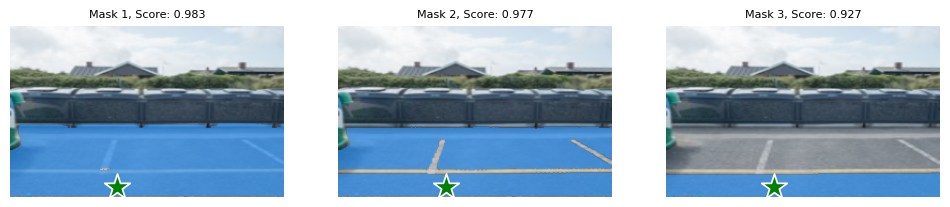

In [8]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, (mask, score) in enumerate(zip(masks, scores)):
    axes[i].imshow(image)
    show_mask(mask, axes[i])
    show_points(input_point, input_label, axes[i])
    axes[i].set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=8)
    axes[i].axis('off')
fig.show()

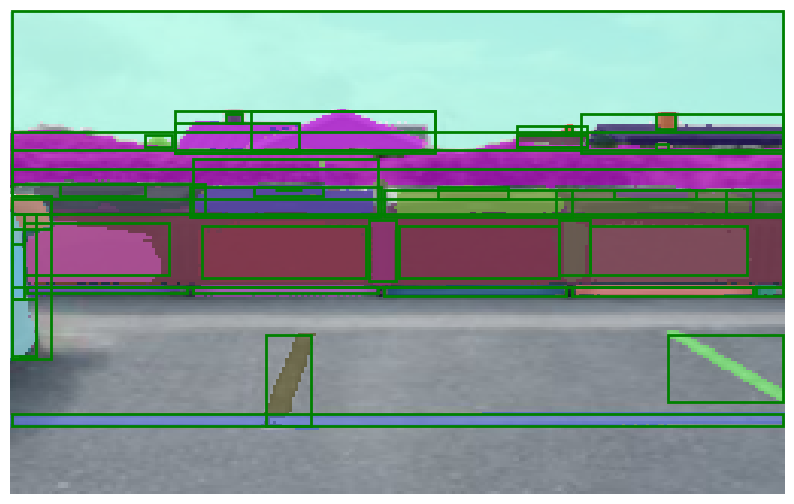

In [9]:
input_boxes, vidx = get_bbox_from_mask(target)
target = target[vidx]
input_boxes = input_boxes.to(predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [10]:
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

def create_sampled_grid(scales, orig_shape):
    y_scale, x_scale = scales
    y_shape, x_shape = orig_shape

    sampled_coord = torch.meshgrid(torch.arange(0, y_shape, y_scale).float(), 
            torch.arange(0, x_shape, x_scale).float())
    
    sampled_coord = torch.stack(sampled_coord, dim=-1)
    print(sampled_coord[..., 0], sampled_coord[..., 1])
    sampled_coord[..., 0] = (sampled_coord[..., 0] - y_shape / 2) / y_shape / 2
    sampled_coord[..., 1] = (sampled_coord[..., 1] - x_shape / 2) / x_shape / 2

    return sampled_coord

# Copy SAM Model
downsampled_sam = deepcopy(sam)

# Hack Patchfy Model
print(sam.image_encoder.patch_embed.proj)

# Since SAM Resolution is 1024 x 1024 \ Current input resolution is 160 x 256
# Y axis - Downsample 6.4 \ X axis - Downsample 4

# print(sam.image_encoder.patch_embed.proj.weight.data.shape)
print(sam.image_encoder.patch_embed.proj.bias.data.shape)
filter_shape = sam.image_encoder.patch_embed.proj.weight.data.shape[-2:]
print(filter_shape)

# # Coordinate Sampling
# sampled_coord = create_sampled_grid((4, 4), filter_shape)

# downsampled_cnn = nn.Conv2d(3, 768, (4, 4), stride=(4, 4), padding=(0, 0))
# downsampled_cnn.cuda()
# sampled_coord = sampled_coord.cuda().unsqueeze(0)
# sampled_coord = sampled_coord.repeat((768, 1, 1, 1))

# downsampled_cnn_weight = F.grid_sample(sam.image_encoder.patch_embed.proj.weight.data, sampled_coord)
# downsampled_cnn.weight.data.copy_(downsampled_cnn_weight)
# downsampled_cnn.bias.data.copy_(sam.image_encoder.patch_embed.proj.bias.data)

# # Assign the new patchfy model
# downsampled_sam.image_encoder.patch_embed.proj = downsampled_cnn

# hack SAM PE module
print(sam.image_encoder.pos_embed.shape)
_, H, W, _ = sam.image_encoder.pos_embed.shape
pos_embed_feature = sam.image_encoder.pos_embed.data[:, :H//4, :W//4, :]
# sampled_coord = create_sampled_grid((6.4, 4), pos_embed_feature.shape[-2:])
# sampled_coord = sampled_coord.cuda().unsqueeze(0)
# sampled_coord = sampled_coord.repeat((768, 1, 1, 1))
# downsampled_pos_embed = F.grid_sample(pos_embed_feature, sampled_coord)
# downsampled_pos_embed = downsampled_pos_embed.permute(0, 2, 3, 1)

del downsampled_sam.image_encoder.pos_embed
downsampled_sam.image_encoder.pos_embed = nn.Parameter(pos_embed_feature)

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
torch.Size([768])
torch.Size([16, 16])
torch.Size([1, 64, 64, 768])


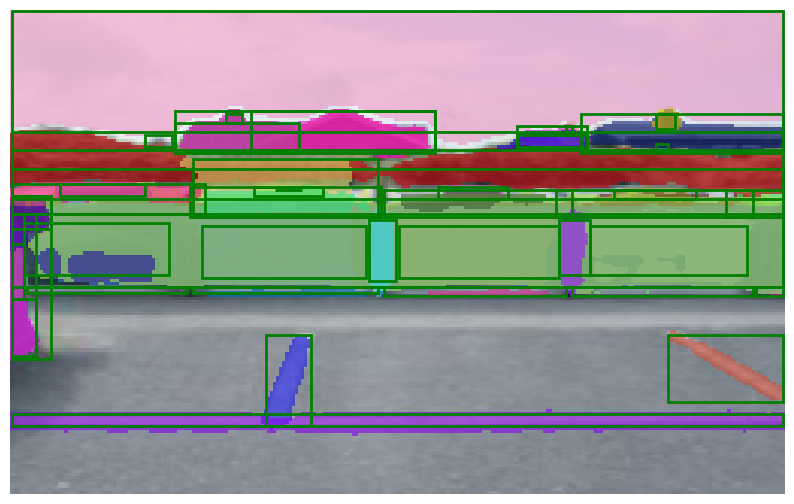

In [11]:
# Test on low resolution
downsampled_sam.image_encoder.img_size = 256
downsampled_sam.prompt_encoder.factor = 4
downsampled_sam.prompt_encoder.image_embedding_size = (16, 16)

predictor = SamPredictor(downsampled_sam)

bbox, vidx = get_bbox_from_mask(target)
target = target[vidx]
bbox = bbox.to(predictor.device)
transformed_boxes = predictor.transform.apply_boxes_torch(bbox, image.shape[:2])

predictor.set_image(image)
masks_low, scores, logits = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks_low:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()
        

tensor(0.7906)


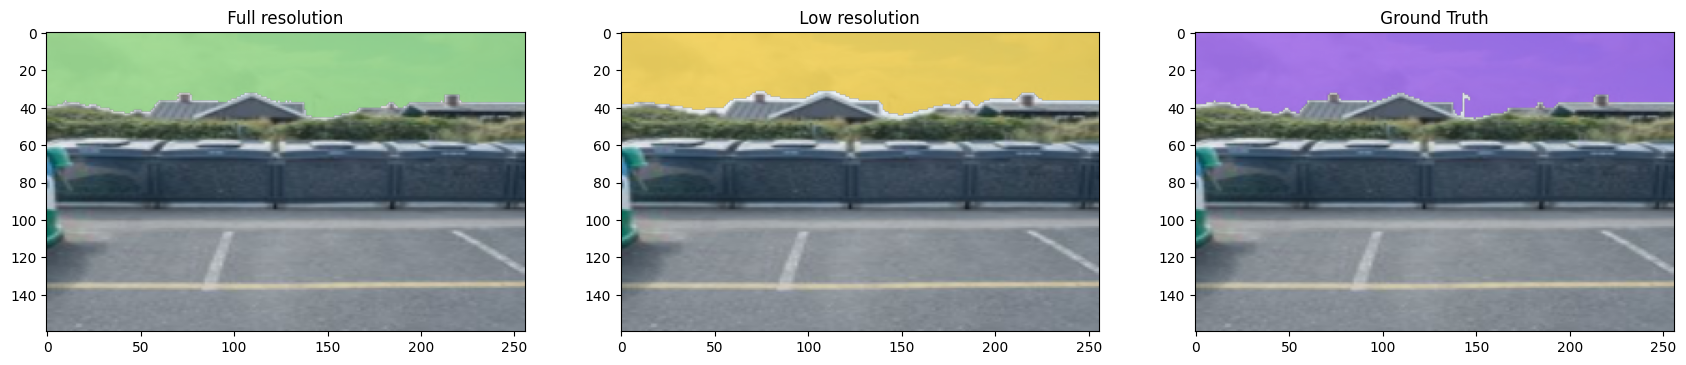

In [17]:
def calculateIoU(pred, gt):
    pred = pred.squeeze(1).cpu()
    
    intersect = (pred * gt).sum(dim=(-1, -2))
    union = pred.sum(dim=(-1, -2)) + gt.sum(dim=(-1, -2)) - intersect
    ious = intersect.div(union)
    return ious

ious = calculateIoU(masks, target)
print(ious.mean())

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
axes[0].imshow(image)
axes[1].imshow(image)
axes[2].imshow(image)

show_mask(masks[28].cpu().numpy(), axes[0], random_color=True)
show_mask(masks_low[28].cpu().numpy(), axes[1], random_color=True)
show_mask(target[28].cpu().numpy(), axes[2], random_color=True)

axes[0].set_title(" Full resolution ")
axes[1].set_title(" Low resolution ")
axes[2].set_title(" Ground Truth ")

# show_box(input_boxes[0].cpu().numpy(), axes[0])
# show_box(input_boxes[0].cpu().numpy(), axes[1])

# fig.axis('off')
fig.show()

In [16]:
from tqdm import tqdm

def test(sam, dataset, test_idx):
    predictor = SamPredictor(sam)
    ious_all = torch.tensor([])
    for t_idx in tqdm(test_idx):
        image, target = dataset[t_idx]
        image = input_reverse_transforms(image)
        image = np.array(image)

        assert len(target) > 0, "zero targets"

        bbox, vidx = get_bbox_from_mask(target)
        target = target[vidx]
        bbox = bbox.to(predictor.device)
        transformed_boxes = predictor.transform.apply_boxes_torch(bbox, image.shape[:2])

        predictor.set_image(image)
        masks, scores, logits = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )

        ious = calculateIoU(masks, target)
        ious_all = torch.cat([ious_all, ious])

    print("Average mIoUs: {:.2f}".format(ious_all.mean()))
    return ious_all

print("test original sam")
test(sam, dataset, list(range(20)))
print("test low sam")
test(downsampled_sam, dataset, list(range(20)))


test original sam


  0%|          | 0/20 [00:00<?, ?it/s]/home/boshulei/.conda/envs/bslei/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Average mIoUs: 0.72
test low sam


100%|██████████| 20/20 [01:07<00:00,  3.40s/it]

Average mIoUs: 0.34


tensor([0.5652, 0.9050, 0.2143,  ..., 0.0000, 0.6946, 0.9107])

In [ ]:
# LoRA Module

